# 0 Introduction
This following notebook is my record of learning [build a nanoGPT from scratch](https://www.bilibili.com/video/BV1qWwke5E3K/?spm_id_from=333.1391.0.0&vd_source=cb269cc6282e6f1fbbb77611c980e39c)

# 1 Import Needed Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from dataclasses import dataclass
import math

torch.manual_seed(1024)  # set seed for reproducibility

# 2. Define GPT2 Configuration

In [2]:
@dataclass  # dataclass is a decorator that automatically generates __init__ and __repr__ methods
class GPT2Config:
    block_size: int = 512  # maximum length of input sequence
    batch_size: int = 12
    n_layer: int = 12
    n_head: int = 12
    n_embed: int = 768  # embedding dimension & hidden dimension
    n_hidden: int = n_embed
    dropout: float = 0.1
    head_size: int = n_embed // n_head  # per-head dimension
    vocab_size: int = 50257

# 3. Define CPT2 Model
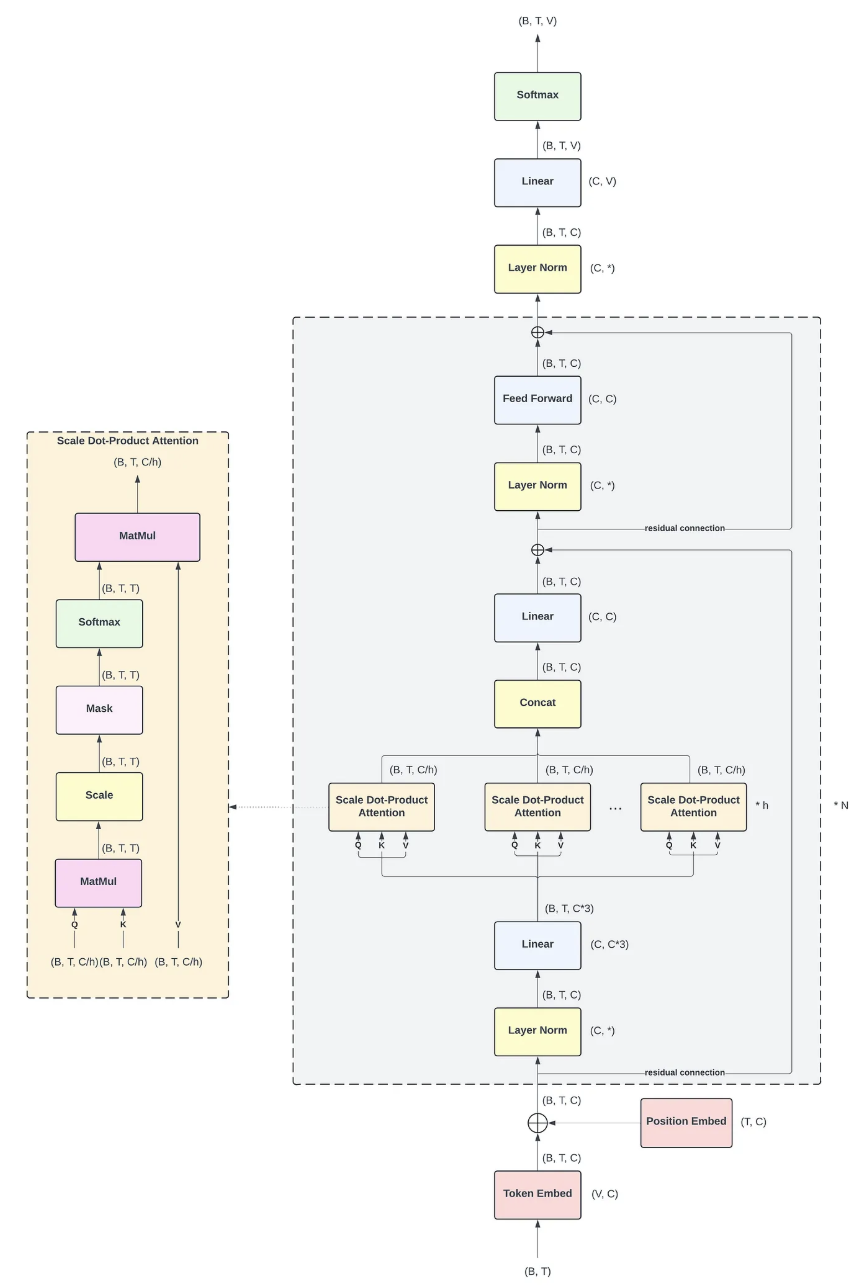

## 3.1 Single-Head Attention

In [8]:
class SingleHeadAttention(nn.Module):
    def ___init__(self, config):
        super().__init__()
        self.query = nn.Linear(config.n_embed, config.head_size)
        self.key = nn.Linear(config.n_embed, config.head_size)
        self.value = nn.Linear(config.n_embed, config.head_size)

        self.register_buffer(
            'attention_mask',
            torch.tril(
                torch.ones(config.block_size, config.block_size)
            )  # lower triangular matrix
        )  # register_buffer is used to save tensors that should be part of the model but not trained
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        batch_size, seq_len, n_hidden = x.size()
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        weight = q @ k.transpose(-2, -1)
        weight = weight / math.sqrt(self.head_size)
        weight = weight.masked_fill(
            self.attention_mask[:seq_len, :seq_len] == 0,
            float('-inf')
        )  # causal masking, each token can only attend to itself and previous tokens
        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)
        out = weight @ v
        return out

## 3.2 Multi-Head Attention

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                SingleHeadAttention(config)
                for _ in range(config.n_head)
            ]
        )
        self.proj = nn.Linear(config.n_hidden, config.n_hidden)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        output = torch.cat(
            [h(x) for h in self.heads],
            dim = -1
        )  # concatenate the output of each head
        output = self.proj(output)
        output = self.dropout(output)
        return output

## 3.3 Feed Forward Neural Network

In [12]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_hidden, 4 * config.n_hidden),
            nn.GELU(),
            nn.Linear(4 * config.n_hidden, config.n_hidden),
            nn.Dropout(config.dropout)
        )

    def forward(self, x):
        return self.net(x)

## 3.4 Transformer Block

In [16]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embed)
        self.mla = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.n_hidden)
        self.ff = FeedForward(config)
    
    def forward(self, x):
        x = x + self.mla(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

## 3.5 GPT2 Model

In [17]:
class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb_table = nn.Embedding(config.vocab_size, config.n_embed)
        self.pos_emb_table = nn.Embedding(config.block_size, config.n_embed)
        self.blocks = nn.Sequential(
            *[Block(config) for _ in range(config.n_layer)]
        )
        self.ln = nn.LayerNorm(config.n_hidden)
        self.head = nn.Linear(config.n_hidden, config.vocab_size, bias=False)  
        # bias is none because of the softmax layer
        # the result with bias and without bias is the same
        
        # tie weights
        self.tok_emb_table.weight = self.head.weight
        
        self.apply(self._init_weights)

    @torch.no_grad()  # prevent the function from being added to the computation graph
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, ids, targets=None):
        batch_size, seq_len = ids.size()
        tok_emb = self.tok_emb_table(ids)
        pos_emb = self.pos_emb_table(
            torch.arange(seq_len, device=ids.device)
        )
        x = tok_emb + pos_emb  
        # why tok_emb and pos_emb can be added directly?
        # 1. they have the same dimension
        # 2. they provide complementary information
        # 3. vector addition is a linear operation  that does not destroy the independence of the original information
        # and the model can learn to separate or combine them
        # why not concatenate them?
        # 1. the dimension of the input will be doubled
        # 2. need more parameters
        x = self.blocks(x)
        x = self.ln(x)
        logits = self.head(x)

        if targets is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.size()
            logits = logits.view(batch_size * seq_len, vocab_size)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)  # do not need to apply softmax before cross_entropy
            # because cross_entropy has a softmax function inside
        return logits, loss

# 4. Define Dataset

In [1]:
class MyDataset(Dataset):
    def __init__(self, path, block_size=512):
        import tiktoken
        self.encoder = tiktoken.get_encoding("gpt2")
        self.block_size = block_size
        self.eos_token = self.encoder.encode(
            "<|endoftext|>",
            allowed_special_tokens={"<|endoftext|>"}
        )[0]  # get the token id of end of text

        import json
        self.encoded_data = []
        raw_data = []
        with open(path, "r") as f:  # read raw json data
            for line in f:
                raw_data.append(json.loads(line.strip())["text"])
        full_encoded = []
        for text in raw_data:  # encode the raw text data
            encoded = self.encoder.encode(text)
            full_encoded.extend(encoded + [self.eos_token])

        # split the full text into chunks
        for i in range(0, len(full_encoded), self.block_size):
            chunk = full_encoded[i:i+self.block_size+1]  # add one more token for target
            if len(chunk) < self.block_size + 1:
                chunk.extend([self.eos_token] * (self.block_size + 1 - len(chunk)))
            self.encoded_data.append(chunk)

        def __len__(self):
            return len(self.encoded_data)
        
        def __getitem__(self, idx):
            chunk = self.encoded_data[idx]
            x = torch.tensor(chunk[:-1], dtype=torch.long)
            y = torch.tensor(chunk[1:], dtype=torch.long)
            return x, y
        
        def encode(self, text):
            return self.encoder.encode(text)
        
        def decode(self, ids):
            return self.encoder.decode(ids)

NameError: name 'Dataset' is not defined

# 5 Prepare Data

In [3]:
config = GPT2Config()

dataset = MyDataset("")
train_dataset, val_dataset = random_split(dataset, [0.9, 0.1])
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)  # shuffle the data to prevent overfitting
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

NameError: name 'MyDataset' is not defined

# 6 Define Hyperparameters

In [ ]:
model = GPT2(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e6} M")

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

# 7 Define Train & Evaluate Functions

In [4]:
def train(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = 0
    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_los += loss.item()
        
        if step % 100 == 0:
            print(f"Epoch: {epoch}, Step: {step}/{len(train_loader)}, Loss: {loss.item():.4f}") 
    return total_loss

def eval(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, y)
            val_loss += loss.item()
    return val_loss

# 8 Training

In [ ]:
from IPython.display import clear_output

for epoch in range(2000):
    train_loss = train(model, optimizer, scheduler, train_loader)
    val_loss = eval(model, val_loader)

    # dynamically drawing the loss curve
    import matplotlib.pyplot as plt
    train_losses = []
    val_losses = []
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if (epoch + 1) % 100 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"GPT2/checkpoint_{epoch}.pt"
